# Draft analysis 

---

Group name: Group C, Burcin Aksel & Nico Henzel

---


## Setup

In [323]:
import pandas as pd
import numpy as np
import missingno as mno # needed to visualize missing values. install missingno into conda if import does not work!
import altair as alt
import matplotlib.pyplot as plt
import plotly.express as px # needed for US map
import xlrd # needed to read excel files. install xlrd into conda if import does not work!
import shutil # needed to copy files
import warnings
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


warnings.simplefilter(action='ignore', category=FutureWarning)
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

## Introduction

The aim of this project is to investigate, whether there is a correlation between the household income and the death rate in the United States of America. In order to explore this relation, we gathered data on both topics and will analyse how and to what extense the death rate is impacted by the household income.

### Research Question

We want to answer the following question:

**Does the household income have an impact on the deathrates in the U.S. and if yes, how big is it?**

The predictor variable will be the median household income and the response variable will be the age-adjusted death rate. Further insights can be gained by using categories like death cause, state or year. Other useful information will be provided by the amount of total deaths.
The data dictionary below, is showing more details about the required variables.

In [324]:
data = {
        'Name': [
                'state',
                'year',
                'median_household_income',
                'cause name',
                '113 cause name',
                'deaths',
                'Age-adjusted Death Rate'
                ], 
        'Description': [
                'the state where data was collected',
                'considered years','median household income',
                'the generic name for the death cause',
                'NDI ICD-10 113 categories for causes of death',
                'count of the total deaths',
                'standardized death percentage for a state'
                ],
        'Role': [
                'predictor',
                'predictor',
                'predictor',
                'predictor',
                'Not used',
                'ID',
                'response'
                ],
        'Type': [
                'nominal',
                'numeric discrete',
                'numeric continuous',
                'nominal',
                'nominal',
                'numeric discrete',
                'numeric continuous'
                ],
        'Format': [
                'category',
                'date',
                'float',
                'category',
                'category',
                'int',
                'float'
                ],
        }
df = pd.DataFrame(data)
df

,Name,Description,Role,Type,Format
0,state,the state where data was collected,predictor,nominal,category
1,year,considered years,predictor,numeric discrete,date
2,median_household_income,median household income,predictor,numeric continuous,float
3,cause name,the generic name for the death cause,predictor,nominal,category
4,113 cause name,NDI ICD-10 113 categories for causes of death,Not used,nominal,category
5,deaths,count of the total deaths,ID,numeric discrete,int
6,Age-adjusted Death Rate,standardized death percentage for a state,response,numeric continuous,float


Our research question is backed by the following studies:
* KINGE, Jonas Minet, et al. Association of household income with life expectancy and cause-specific mortality in Norway, 2005-2015. Jama, 2019, 321. Jg., Nr. 19, S. 1916-1925. (https://jamanetwork.com/journals/jama/article-abstract/2733322)
* KAPLAN, George A., et al. Inequality in income and mortality in the United States: analysis of mortality and potential pathways. Bmj, 1996, 312. Jg., Nr. 7037, S. 999-1003. (https://www.bmj.com/content/312/7037/999.full)
* O’CONNOR, Gerald T., et al. Median household income and mortality rate in cystic fibrosis. Pediatrics, 2003, 111. Jg., Nr. 4, S. e333-e339. (https://publications.aap.org/pediatrics/article-abstract/111/4/e333/63113/Median-Household-Income-and-Mortality-Rate-in)

Although the first study was done in Norway and the second study investigates mortality instead of death rate, we suspect to gather similar observations.
Therefore our hypotheses regarding the research question is:

**The household income and the death rate will have a negative correlation.**

Meaning, that the higher the household income is, the lower the death rate will be.

Added information on mortality rate:
*Mortality is a fact that refers to susceptibility to death. While there is a crude death rate that refers to number of deaths in a population in a year, mortality rate is the number of deaths per thousand people over a period of time that is normally a year.* (see: https://www.differencebetween.com/difference-between-death-rate-and-vs-mortality-rate/).

## Data

## Import data

In [325]:
# Declare variables
external_data = '..\\data\\external\\'
raw_data = '..\\data\\raw\\'
# File names
orig_income_file = 'Median_Household_Income_By_State_1990-2017.xls'
target_income_file = 'Median_Household_Income_By_State_1990-2017.csv'
orig_death_file = 'NCHS_-_Leading_Causes_of_Death__United_States.csv'
# Save external median income data as csv in folder 'raw'
# Read file
xls_household_file = pd.read_excel(external_data+orig_income_file)
# Save file
xls_household_file.to_csv(raw_data+target_income_file,index = None, header=True)
# Copy external leading cause of death data into folder 'raw'
shutil.copy(external_data+orig_death_file, raw_data+orig_death_file)

'..\\data\\raw\\NCHS_-_Leading_Causes_of_Death__United_States.csv'

In [326]:
# Declare both dataframes
df_income = pd.read_csv(raw_data+target_income_file)
df_death = pd.read_csv(raw_data+orig_death_file)

### Data structure

In [327]:
df_death.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10868 entries, 0 to 10867
Data columns (total 6 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Year                     10868 non-null  int64  
 1   113 Cause Name           10868 non-null  object 
 2   Cause Name               10868 non-null  object 
 3   State                    10868 non-null  object 
 4   Deaths                   10868 non-null  int64  
 5   Age-adjusted Death Rate  10868 non-null  float64
dtypes: float64(1), int64(2), object(3)
memory usage: 509.6+ KB


In [328]:
df_death.head()

,Year,113 Cause Name,Cause Name,State,Deaths,Age-adjusted Death Rate
0,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,United States,169936,49.4
1,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alabama,2703,53.8
2,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Alaska,436,63.7
3,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arizona,4184,56.2
4,2017,"Accidents (unintentional injuries) (V01-X59,Y8...",Unintentional injuries,Arkansas,1625,51.8


In the death dataset we have 10868 cases and 6 columns.

The columns are:
* years, from 1999 to 2017
* 113 cause name, the NDI ICD-10 113 categories for causes of death
* cause name, the generic name for the death cause defined in the 113 cause name column
* state, in which state the data was collected
* death, the count of the total deaths 
* age-adjusted death rate, the standardized death percentage for the specific state in the observed year

In [329]:
df_income.head()

,"Table 102.30. Median household income, by state: Selected years, 1990 through 2017",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31
0,[In constant 2017 dollars. Standard errors app...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,State,1990\1\,2000\2\,2005.0,NaN,2010.0,NaN,2013.0,NaN,2014.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,2,3,4.0,NaN,5.0,NaN,6.0,NaN,7.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,
3,United States ...........,57500,62000,58200.0,80.0,56400.0,40.0,55100.0,40.0,55600.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama ....................,45200,50400,46400.0,400.0,45600.0,320.0,45200.0,410.0,44400.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Data corrections

In order to use machine learning models on the data, we need to make some corrections to obtain 'tidy' data.

#### Income Dataset

First we correct the data for the median household income by state.

From the overview, we have seen that this dataset needs to be cleaned, by following steps:

* define column names
* remove columns and rows with only null values
* remove unnecessary characters such as whitespaces or trailing dots

In [331]:
# We only need the first 16 columns 
# and we can also drop the columns 4,6,8,10,12 and 14 since they only show NaN values
column_lst = [0,1,2,3,5,7,9,11,13,15]
df_income_corrected = df_income[df_income.columns[column_lst]]
# We don't need row 0,2 and row 64-67
row_drop_lst = [0,2,64,65,66,67]
df_income_corrected = df_income_corrected.drop(row_drop_lst)
# There are a few rows with empty entries left, which we can get rid off 
# since those rows have no state assigned to it, they are only used as separators
df_income_corrected.dropna(inplace=True)
# The column names are actually in the first row, additionally they need to be adjusted
column_names = ['State','1990','2000','2005','2010','2013','2014','2015','2016','2017']
df_income_corrected.columns = column_names
# Row number 1 can be dropped
df_income_corrected.drop(1,inplace=True)
# The dots in the state column can be removed
# We also do not want any leading or ending spaces in the strings
df_income_corrected = df_income_corrected.replace(r'\.','',regex=True)
df_income_corrected['State'] = df_income_corrected['State'].str.strip()
# Lastly we reset the row index drop the old index 
df_income_corrected.reset_index(drop = True, inplace = True)


We also need to:

* transform the whole dataset
* rename the columns to be lowercase
* declare correct column types

In [332]:
# We transform the table to show the median income for a state in a single year
# We use the melt() function for this
lst_years = column_names[1:]
df_income_corrected = df_income_corrected.melt(
    id_vars= ['State'], 
    value_vars= lst_years, 
    var_name= 'year', 
    value_name= 'median_household_income' 
    )

# The State column should be lowercase
df_income_corrected = df_income_corrected.rename(
    columns = {'State':'state'}
)
# The types need to be declared, state holds categorial values, year has integers and income holds float numbers
df_income_corrected['state'] = df_income_corrected['state'].astype('category')
df_income_corrected['year'] = df_income_corrected['year'].astype('int')
df_income_corrected['median_household_income'] = df_income_corrected['median_household_income'].astype('float')

In [333]:
df_income_corrected.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468 entries, 0 to 467
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   state                    468 non-null    category
 1   year                     468 non-null    int32   
 2   median_household_income  468 non-null    float64 
dtypes: category(1), float64(1), int32(1)
memory usage: 8.5 KB


In [334]:
df_income_corrected.head()

,state,year,median_household_income
0,United States,1990,57500.0
1,Alabama,1990,45200.0
2,Alaska,1990,79300.0
3,Arizona,1990,52700.0
4,Arkansas,1990,40500.0


In [335]:
file = 'Corrected_Median_Household_Income_By_State_1990-2017.csv'
df_income_corrected.to_csv(raw_data+file,index = None, header=True)

We prepared the income data set in order to use it for our project. 
The original .xls data can be found in the data folder under external or the .csv under the folder raw.

Now, we are able to add, the median household income to the death dataset by adding the corresponding value to the correct year and state present in the death dataset. Before that, we also need to correct the death dataset.

#### Death Dataset

From the overview of the death dataset, we see the following things:

* The Dtypes 113 Cause Name, Cause Name and State need to be changed to category
* The year, deaths and death rate column already have the right typing
* The column names need to be adjusted to be lowercase and have underscores instead of spaces
* Also, there are no missing values present in the dataset

In [336]:
# Make a copy to perform corrections on
df_death_corrected = df_death
# Change column names to lowercase
df_death_corrected.columns = df_death_corrected.columns.str.lower()
# Change spaces and the '-' to underscores
df_death_corrected.columns = df_death_corrected.columns.str.replace(r' ','_',regex=True)
df_death_corrected.columns = df_death_corrected.columns.str.replace(r'-','_',regex=True)
# Remove any leading or trailing whitespaces for the object columns
df_death_corrected['113_cause_name'] = df_death_corrected['113_cause_name'].str.strip()
df_death_corrected['cause_name'] = df_death_corrected['cause_name'].str.strip()
df_death_corrected['state'] = df_death_corrected['state'].str.strip()
# Change Dtype of 113 Cause Name, Cause Name and State column to category
cols = df_death_corrected.select_dtypes(include='object').columns.to_list()
df_death_corrected[cols] = df_death_corrected[cols].astype('category')

#### Joined Dataset

Next we add the median household column from the income dataset to the death dataset by adding it to the corresponding state and year.

In [337]:
df_joined = pd.merge(
    df_death_corrected,
    df_income_corrected,
    how = 'left',
    on = ['year','state']
)

We take a look at the joined dataset to see if we need to do anything before using it:

In [338]:
df_joined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10868 entries, 0 to 10867
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   year                     10868 non-null  int64   
 1   113_cause_name           10868 non-null  category
 2   cause_name               10868 non-null  category
 3   state                    10868 non-null  category
 4   deaths                   10868 non-null  int64   
 5   age_adjusted_death_rate  10868 non-null  float64 
 6   median_household_income  4576 non-null   float64 
dtypes: category(3), float64(2), int64(2)
memory usage: 459.6 KB


#### Imputed Dataset

# VERWEIS EINFÜGEN
We will impute the missing values by using a KNN Imputation since that will typically result in a good imputation for numerical values. In the appendix, you can find the imputation analysis and statistics in detail.

The data needs to be scaled in order for the algorithm to perform well.

In [339]:
# Only keep numerical columns
col_num = df_joined.select_dtypes(include=[np.number]).columns.to_list()

# Original household median income 
original_df_joined = df_joined[col_num]

# Scaled household median income
scaler = MinMaxScaler()
scaled_df_joined = scaler.fit_transform(original_df_joined)
scaled_df_joined = pd.DataFrame(data=scaled_df_joined, columns=original_df_joined.columns)
scaled_df_joined.head()

,year,deaths,age_adjusted_death_rate,median_household_income
0,1.0,0.060393,0.043146,0.478774
1,1.0,0.000953,0.047202,0.191038
2,1.0,0.000148,0.056329,0.783019
3,1.0,0.001480,0.049415,0.391509
4,1.0,0.000570,0.045358,0.139151


After the imputation, we’ll have to use the inverse_transform() function from MinMaxScaler to bring the scaled dataset in the original form:

In [340]:
# Impute
imputer_scaled = KNNImputer(n_neighbors=1)
imputed_scaled = imputer_scaled.fit_transform(scaled_df_joined)

# Convert to DataFrames
imputed_scaled = pd.DataFrame(data=imputed_scaled, columns=original_df_joined.columns)

# Inverse the scaling
imputed_scaled = scaler.inverse_transform(imputed_scaled)
imputed_scaled = pd.DataFrame(data=imputed_scaled, columns=original_df_joined.columns)

In [341]:
# Save the imputed values in the joined dataframe
df_joined['median_household_income'] = imputed_scaled['median_household_income']

### Variable lists

# VERWEIS EINFÜGEN
The list of used variables with a data dictionary can be found in the table under introduction.

In [342]:
# define outcome variable as y_label
y_label = 'age_adjusted_death_rate'
# list of all numerical data without y_label
list_num = df_joined.select_dtypes(include=[np.number]).columns.tolist()
list_num.remove(y_label)
list_num.remove('year')
# list of all categorical data
list_cat = df_joined.select_dtypes(include=['category']).columns.tolist()
# select features
features = df_joined.drop(columns=[y_label]).columns.tolist()
# create feature data for data splitting
X = df_joined[features]
# create response for data splitting
y = df_joined[y_label]

### Data splitting

In [343]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# data training set
df_train = pd.DataFrame(X_train.copy())
df_train = df_train.join(pd.DataFrame(y_train))

## Analysis

Our response variable is the age-adjusted death rate.
This variable shows the standardized percentage of deaths in a specific year for a specific state (adjusted for the age factor).

The predictor variable will be the median household income. We will focus on the relation between the median income and the death rate for all death causes. Although we suspect the death cause, year and the state to be indicators for variation on a more detailed level. This can give us insights and potential relevant information for our model or fduring the data exploration.

In order to test our hypotheses we will inspect summary statistics and use different visualizations in order to understand the relations between the predictor and response variables and gain further knowledge.

First we copy the training dataframe into another variable. This way we prevent the training data to be accidentally changed during data exploration:

In [344]:
df_explore = df_train

### Descriptive statistics

Let's take a look at the exploration dataframe:

In [345]:
df_explore.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
year,7607.0,2007.97,5.47,1999.0,2003.0,2008.0,2013.0,2017.0
deaths,7607.0,14941.20,108968.33,21.0,616.0,1734.0,5802.5,2813503.0
median_household_income,7607.0,57785.01,9368.38,40000.0,50400.0,55800.0,63400.0,82400.0
age_adjusted_death_rate,7607.0,126.77,221.84,2.6,19.2,36.0,153.2,1061.2


In [346]:
# Interquartile ranges
q1 = df_explore.quantile(q = 0.25)
q3 = df_explore.quantile(q = 0.75)
iqr = q3-q1
iqr

year                          10.0
deaths                      5186.5
median_household_income    13000.0
age_adjusted_death_rate      134.0
dtype: float64

We can see that our lowest value for year is 1999 and the highest is 2017.

The statistics for the total amount of deaths are similar to the death rate regarding the difference from minumum and maximum values as well as the range from the third quartile to the maximum.
Our first interpretation is that the summarized values for every cause of death (described with the category 'All causes') could lead to the effect seen in the table above.

We will check those interpretations in the exploratory data analysis and provide a more detailed interpretation for the age adjusted death rate as well as the median household income.

### Exploratory data analysis

First we visualize the distribution for the age adjusted death rate

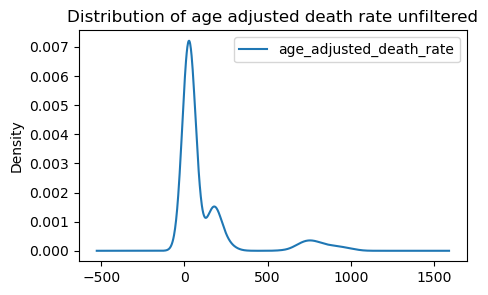

In [397]:
# Distribution of age_adjusted_death_rate
df_explore[['age_adjusted_death_rate']].plot(
    kind='kde',
    figsize=(5, 3),
    title='Distribution of age adjusted death rate unfiltered')

plt.legend(prop={'size': 10})

The statistic and distribution for the age adjusted death rate show:
* 75 % of the values are at or below 153.2 while the maximum goes up to 1061.2. This is a heavily right skewed distribution with alot of outliers since the IQR is at 134.
* The distribution visualizes this effect but does not explain it yet.
* The standard deviation shows that the values differ alot from the mean (relative to the first three quartiles) which can also explained with the skew.

The distribution is right skewed but also bimodal. We will take a more detailed look at a bar plot to explore the reason for this distribution.

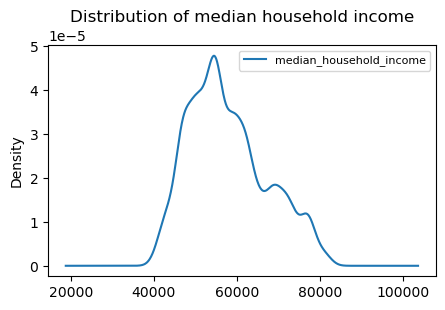

In [400]:
# Distribution of median_household_income
df_explore[['median_household_income']].plot(
    kind='kde',
    figsize=(5, 3),
    title='Distribution of median household income')

plt.legend(prop={'size': 8})

# VERWEIS EINFÜGEN

The summary statistics in combination with the distribution show:

* The distribution is unimodal and right skewed extending from 40k \$ to over 80k $.
* The median is found at 56350 $ and with an IQR at 13000 there are no outliers present in the income data.
* The median (55800 $) is not in the middle between minimum and maximum (which would be around the mark where the third quartile is). This means the distribution is right skewed.

The imputed data is very close to the origina data present in the income dataset. A comparison for the distribution before and after the imputation can be found in the appendix.

# Visualisierung wiederholen als bar plot mit Kategorien für Death causes, um Bimodale Verteilung zu erklären !

In [349]:
# Logarithmische skala für count, kategorien, title, x-achse. legende

alt.Chart(df_explore[['age_adjusted_death_rate']]).mark_bar().encode(
    alt.X("age_adjusted_death_rate:Q", bin=True),
    y='count()',
)

alt.Chart(...)

We can see that the distribution looks like this because the cause_name feature has individual causes as well as a summary for all causes within the same column.

We will make another dataframe filtered by all causes to serve as a summary dataset:

In [350]:
df_explore_causes_summarized = df_explore[df_explore.cause_name == 'All causes']

Let's look at the statistics and distribution of the age adjusted death rate again

In [351]:
df_explore_causes_summarized[['age_adjusted_death_rate']].describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
age_adjusted_death_rate,675.0,800.13,98.12,572.0,724.4,784.5,869.5,1061.2


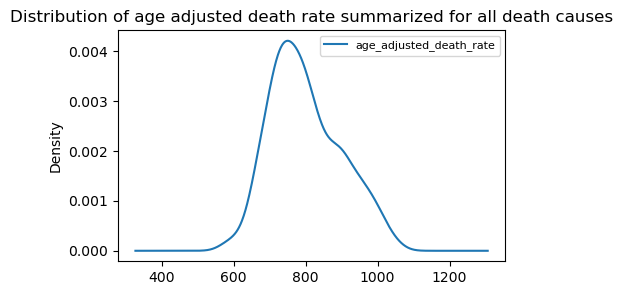

In [401]:
# Distribution of age_adjusted_death_rate
df_explore_causes_summarized[['age_adjusted_death_rate']].plot(
    kind='kde',
    figsize=(5, 3),
    title='Distribution of age adjusted death rate summarized for all death causes'
      )

plt.legend(prop={'size': 8})

We can see that the distribution has changed:
* The distribution is unimodal and still right skewed but alot closer to a normal distribution 
* We do not observe the wide range of values as before, there are no more outliers present
* The mean is still higher than the median, which can be explained by the amount of high values around 900-1000.

In [353]:
fig = px.choropleth(df_explore_causes_summarized,
                    locations='state', 
                    locationmode="USA-states", 
                    scope="usa",
                    color='median_household_income',
                    color_continuous_scale="Viridis", 
                    
                    )

fig.update_layout(
      title_text = 'Distribution of median household income in the US',
      title_font_family="Times New Roman",
      title_font_size = 22,
      title_font_color="black", 
      title_x=0.45, 
         )
fig.show()

# Ausprobieren, ob Einfärbung nach Jahren sinnvoll ist

In [354]:
alt.Chart(df_explore_causes_summarized).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
).interactive()


alt.Chart(...)

In this chart, there is a clear negative correlation between the median household income and the age adjusted death rate. The more the median income is, the less the deaths are appearing.

In [355]:
Chart_CLRD=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal='CLRD',)

).interactive()

Chart_Alzheimer=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Alzheimer's disease")

).interactive()

Chart_Influenza=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Influenza and pneumonia")

).interactive()

Chart_Suicide=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Suicide")

).interactive()

Chart_Kidney=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Kidney disease")

).interactive()

Chart_Unintentional=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Unintentional injuries")

).interactive()

Chart_Diabetes=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Diabetes")

).interactive()

Chart_Stroke=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Stroke")

).interactive()

Chart_Cancer=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Cancer")
    
    ).interactive()
    
Chart_Heart=alt.Chart(df_explore).mark_circle(size=60).encode(
    alt.X('median_household_income', scale = alt.Scale(zero = False)),
    alt.Y('age_adjusted_death_rate' , scale = alt.Scale(zero = False)),
    color='cause_name',
    tooltip = ['median_household_income', 'age_adjusted_death_rate']
    ).properties(
    width=150,
    height=150
).transform_filter(
    alt.FieldEqualPredicate(field='cause_name', equal="Heart disease")

).interactive()

Horizontal1=Chart_CLRD | Chart_Alzheimer | Chart_Diabetes 
Horizontal2=Chart_Kidney | Chart_Suicide | Chart_Influenza 
Horizontal3=Chart_Stroke | Chart_Cancer | Chart_Heart | Chart_Unintentional
alt.vconcat(Horizontal1, Horizontal2, Horizontal3)

alt.VConcatChart(...)

These charts are showing all death causes in detail. We have one chart for each death cause. Also there is the same negative correlation as in the plot for all death causes. It seems like, that the death cause is only slightly influencing this correlation. Cancer seems like the death cause with the strongest negative correlation.

### Relationships

We will first look at the correlation of all features and then inspect the correlation for our summarized dataframe

In [356]:
#identify all categorical variables
list_cat = df_explore.select_dtypes(['category']).columns
#convert all categorical variables to numeric
df_explore[list_cat] = df_explore[list_cat].apply(lambda x: pd.factorize(x)[0])

In [357]:
# inspect correlation between outcome and possible predictors
corr = df_explore.corr()
corr[y_label].sort_values(ascending=False)

age_adjusted_death_rate    1.000000
113_cause_name             0.402470
cause_name                 0.402470
deaths                     0.224213
state                      0.005450
year                      -0.027888
median_household_income   -0.031676
Name: age_adjusted_death_rate, dtype: float64

In [358]:
# take a look at all correlations
corr.style.background_gradient(cmap='Blues')

,year,113_cause_name,cause_name,state,deaths,median_household_income,age_adjusted_death_rate
year,1.000000,0.005480,0.005480,0.002946,0.013353,-0.077663,-0.027888
113_cause_name,0.005480,1.000000,1.000000,0.007820,0.097992,-0.015742,0.402470
cause_name,0.005480,1.000000,1.000000,0.007820,0.097992,-0.015742,0.402470
state,0.002946,0.007820,0.007820,1.000000,0.004487,-0.023781,0.005450
deaths,0.013353,0.097992,0.097992,0.004487,1.000000,0.005334,0.224213
median_household_income,-0.077663,-0.015742,-0.015742,-0.023781,0.005334,1.000000,-0.031676
age_adjusted_death_rate,-0.027888,0.402470,0.402470,0.005450,0.224213,-0.031676,1.000000


We can see that both features 113_cause_name and cause_name provide the same information. Like we predicted we only need to keep one column for the model. Therefore we will drop the column '113_cause_name'.

We can ignore the obvious correlations between the age_adjusted_death_rate and cause_name, or deaths as well as deaths and cause_name, since those do not provide extra information.

For the summarized dataframe, the correlation matrix looks like this:

In [359]:
# inspect correlation for summarized cause name again
corr = df_explore_causes_summarized.corr()
corr.style.background_gradient(cmap='Blues')

,year,deaths,median_household_income,age_adjusted_death_rate
year,1.000000,0.033989,-0.078670,-0.446958
deaths,0.033989,1.000000,0.005858,-0.045224
median_household_income,-0.078670,0.005858,1.000000,-0.512797
age_adjusted_death_rate,-0.446958,-0.045224,-0.512797,1.000000


The correlation matrix shows, that there is a high negative correlation for year and median_household_income. That means, that our hyphothesis is supported by the data. The data shows in addition, that the more years pass, the less people die (looking at data from 1999-2017) which could be explained by the improvements in the medical sector as well as the standard of living. To verifiy this assumption we would need more data.

No other significant correlation is visible.

## Model

### Model type
Since the predictor and the response variable are numeric, and we try to find a patter between them, we have a regression problem.

We will start with simple linear regression even though we do not assume a linear relationship. 
In addition we use lasso regression and compare both models to see which performs better. 

We will only use the variable 'all causes' and filter the death rates by it, because we focus on the total deathrate in relation to the median household income.

Before we start we encode the categorical features as numeric features for the models and perform the data splitting again since we made changes:

In [360]:
# drop 113_cause_name column
df_joined.drop(['113_cause_name'], axis = 1, inplace = True)
# Filter only for cause_name = 'all_causes'
df_joined_summarized =  df_joined[df_joined.cause_name == 'All causes']
#identify all categorical variables
list_cat = df_joined_summarized.select_dtypes(['category']).columns
#convert all categorical variables to numeric
df_joined_summarized[list_cat] = df_joined_summarized[list_cat].apply(lambda x: pd.factorize(x)[0])

C:\Users\Nico\AppData\Local\Temp\ipykernel_6748\261981269.py:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [361]:
# Perform data splitting
y_label = 'age_adjusted_death_rate'
features = df_joined_summarized.drop(columns=[y_label]).columns.tolist()
X = df_joined_summarized[features]
y = df_joined_summarized[y_label]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# data training set
df_train = pd.DataFrame(X_train.copy())
df_train = df_train.join(pd.DataFrame(y_train))

## Linear Regression

### Select model

In [362]:
# select the linear regression model
reg_lin = LinearRegression()

### Training and validation

In [363]:
# cross-validation with 5 folds
scores_lin = cross_val_score(reg_lin, X_train, y_train, cv=5, scoring='neg_mean_squared_error') *-1
scores_lin

array([4418.61858962, 4929.91323129, 4915.08870534, 5396.78355687,
       4622.72809773])

In [364]:
# store cross-validation scores
df_scores_lin = pd.DataFrame({"lr": scores_lin})

# reset index to match the number of folds
df_scores_lin.index += 1

# print dataframe
df_scores_lin.style.background_gradient(cmap='Blues')

,lr
1,4418.618590
2,4929.913231
3,4915.088705
4,5396.783557
5,4622.728098


In [365]:
alt.Chart(df_scores_lin.reset_index()).mark_line(
     point=alt.OverlayMarkDef()
).encode(
    x=alt.X("index", bin=False, title="Fold", axis=alt.Axis(tickCount=5)),
    y=alt.Y("lr", aggregate="mean", title="Mean squared error (MSE)")
)

alt.Chart(...)

In [366]:
df_scores_lin.describe().T

,count,mean,std,min,25%,50%,75%,max
lr,5.0,4856.626436,369.837063,4418.61859,4622.728098,4915.088705,4929.913231,5396.783557


### Fit model

In [367]:
# Fit the model to the complete training data
reg_lin.fit(X_train, y_train)

LinearRegression()

Coefficients

In [368]:
# intercept
intercept = pd.DataFrame({
    "Name": ["Intercept"],
    "Coefficient":[reg_lin.intercept_]}
    )

# make a slope table
slope = pd.DataFrame({
    "Name": features,
    "Coefficient": reg_lin.coef_}
)

# combine estimates of intercept and slopes
table = pd.concat([intercept, slope], ignore_index=True, sort=False)

round(table, 3)

,Name,Coefficient
0,Intercept,19659.063
1,year,-9.232
2,cause_name,0.000
3,state,-0.013
4,deaths,-0.000
5,median_household_income,-0.005


### Evaluation on test set

In [369]:
# obtain predictions
y_pred_lin = reg_lin.predict(X_test)

In [370]:
# R squared
r2_score(y_test, y_pred_lin).round(3)

0.491

In [371]:
# MSE
mean_squared_error(y_test, y_pred_lin).round(3)

4615.369

In [372]:
# RMSE
mean_squared_error(y_test, y_pred_lin, squared=False).round(3)

67.937

In [373]:
# MAE
mean_absolute_error(y_test, y_pred_lin).round(3)

56.018

## Lasso Regression

In [374]:
X_train

,year,cause_name,state,deaths,median_household_income
9798,2000,0,21,43753,78000.0
9826,2000,0,50,46461,64600.0
7496,2004,0,8,7143,53900.0
9814,2000,0,39,130813,59200.0
4096,2010,0,36,108711,50800.0
...,...,...,...,...,...
1198,2015,0,2,4316,75900.0
2922,2012,0,7,29316,70700.0
9232,2001,0,28,15174,57900.0
4649,2009,0,5,232736,65000.0


In [375]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train[list_num]) 

X_train[list_num] = scaler.transform(X_train[list_num])
X_test[list_num] = scaler.transform(X_test[list_num])

In [376]:
# select the lasso regression model
reg_las = Lasso(alpha=1)

### Training and validation

- Auf cause names eingrenzen und rote Linie ziehen.
- Für Lasso Reg. das gleiche machen

In [377]:
# cross-validation with 5 folds
scores_las = cross_val_score(reg_las, X_train, y_train, cv=5, scoring='neg_mean_squared_error') *-1
scores_las

array([4415.12054022, 4950.74607096, 4913.44349564, 5393.76767677,
       4625.52543823])

In [378]:
# store cross-validation scores
df_scores_las = pd.DataFrame({"lr": scores_las})

# reset index to match the number of folds
df_scores_las.index += 1

# print dataframe
df_scores_las.style.background_gradient(cmap='Blues')

,lr
1,4415.120540
2,4950.746071
3,4913.443496
4,5393.767677
5,4625.525438


In [379]:
alt.Chart(df_scores_las.reset_index()).mark_line(
     point=alt.OverlayMarkDef()
).encode(
    x=alt.X("index", bin=False, title="Fold", axis=alt.Axis(tickCount=5)),
    y=alt.Y("lr", aggregate="mean", title="Mean squared error (MSE)")
)

alt.Chart(...)

In [380]:
df_scores_las.describe().T

,count,mean,std,min,25%,50%,75%,max
lr,5.0,4859.720644,370.437125,4415.12054,4625.525438,4913.443496,4950.746071,5393.767677


### Fit model

In [381]:
# Fit the model to the complete training data
reg_las.fit(X_train, y_train)

Lasso(alpha=1)

Coefficients

In [382]:
# intercept
intercept = pd.DataFrame({
    "Name": ["Intercept"],
    "Coefficient":[reg_las.intercept_]}
    )

# make a slope table
slope = pd.DataFrame({
    "Name": features,
    "Coefficient": reg_las.coef_}
)

# combine estimates of intercept and slopes
table = pd.concat([intercept, slope], ignore_index=True, sort=False)

round(table, 3)

,Name,Coefficient
0,Intercept,19234.308
1,year,-9.179
2,cause_name,0.000
3,state,0.004
4,deaths,-2.201
5,median_household_income,-51.473


### Evaluation on test set

In [383]:
# obtain predictions
y_pred_las = reg_las.predict(X_test)

In [384]:
# R squared
r2_score(y_test, y_pred_las).round(3)

0.491

In [385]:
# MSE
mean_squared_error(y_test, y_pred_las).round(3)

4611.009

In [386]:
# RMSE
mean_squared_error(y_test, y_pred_las, squared=False).round(3)

67.904

In [387]:
# MAE
mean_absolute_error(y_test, y_pred_las).round(3)

56.03

### Save model



Save your model in the folder `models/`. Use a meaningful name and a timestamp.

Wiederholudng für Lasso Regression

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X_train[list_numerical]) 

X_train[list_numerical] = scaler.transform(X_train[list_numerical])
X_test[list_numerical] = scaler.transform(X_test[list_numerical])

## Conclusions

- Hypothese wurde bestätigt, mit Model untermauert
- Model ergebnisse erklären, was sagen inhalte aus
- in bestimmten Staaten sind bestimmte Todesursachen besonders ausgeprägt
- Verhätnis zwischen Todesrate und Einkommen könnte man noch detaillierter betrachten, wenn man auf die einzelnen Todesursachen eingeht, hinsichtlich Korrelation --> vielleicht, steigt bei gewissen Todesursachen die Rate mit steigendem Einkommen.
